[View in Colaboratory](https://colab.research.google.com/github/wayne1123/Topic/blob/master/NN_with_PyTorch.ipynb)

In [155]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


### Making Neural Network using Numpy style PyTorch Only

Data Set : MNIST <br/>
Optimizer : Stochastic Gradient Descent <br/>
Architecture: 1 Hidden Layer (Dense + ReLU, 250 neurons) & 1 Output Layer(Dense + Softmax for 10-class) <br/>
Initialization: He initialization<br/>
Batch Size: 250 <br/>



In [0]:
import numpy as np
from torchvision import datasets, transforms

### Loading MNIST data using torchvision.datasets.MNIST

In [0]:
BATCH_SIZE = 250
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)
testset = datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=4)

In [0]:
def to_categorical(y):
  y_cat = torch.zeros(y.shape[0], 10)
  y_cat[range(250),y] = 1
  return y_cat

In [0]:
def preprocess(x, y):
  x = x.reshape(-1, 784)
  #y = to_categorical(y)
  return x, y

In [0]:
data = iter(trainloader)
x_, y_ = data.next()
x_, y_ = preprocess(x_, y_)

### Initialization

He initialization : https://arxiv.org/pdf/1502.01852.pdf

$W\sim Normal(0, \frac{2}{f_{in}})$

For bias, there is no consensus how to initialize it. Since the weight matrix is initialized as normal distribution, the asymmetry breaking is already done. Some prefer to initialize the bias as 0.01 in order to activate ReLU function, but its effects are not yet confirmed.

In [0]:
def he_init(W):
  dims = W.shape
  if len(dims) > 2:
    fan_out = np.prod(dims[-1])
    fan_in = dims[:-1]
  else:
    fan_out = dims[1]
    fan_in = dims[0]
  stddev = np.sqrt(2/fan_in)
  W_out = torch.randn(fan_in, fan_out) * stddev
  W_out = torch.min(W_out, torch.ones_like(W_out))
  W_out = torch.max(W_out, torch.ones_like(W_out) * (-1))
  W_out = W_out.reshape(W.shape)
  return W_out

In [0]:
W1 = torch.zeros(784, 250)
b1 = torch.zeros(1, 250)
W2 = torch.zeros(250, 10)
b2 = torch.zeros(1, 10)

In [0]:
W1 = he_init(W1)
W2 = he_init(W2)

### Linear function


Z = XW + b <br/>
$\frac{\partial L}{\partial X}=\frac{\partial L}{\partial Z}\frac{\partial Z}{\partial X}$ by Chain Rule

L is the loss  function, and $\frac{\partial L}{\partial Z}$ is the gradient from the previous layer(previous in terms of back-propagation)

In [0]:
def linear_forward(x, w, b):
  out = torch.mm(x, w) + b
  cache = (x,w,b)
  return out, cache

In [0]:
def linear_backward(dz, cache):
  x, w, b = cache
  dw = torch.mm(x.permute(1,0), dz)
  dx = torch.mm(dz, w.permute(1,0))
  db = torch.sum(dz, 0) # Sum over 0 axis
  return dw, dx, db

### Output function

$Relu(x) = max(x, 0)$ <br/>

In [0]:
def relu_forward(x):
  cache = x
  return torch.max(x, torch.zeros_like(x)), cache
  

In [0]:
h1, h1_cache = linear_forward(x_, W1, b1)
y1, y1_cache = relu_forward(h1)
h2, h2_cache = linear_forward(y1, W2, b2)

In [0]:
def relu_backward(dz, cache):
  x = cache
  z = torch.max(x, torch.zeros_like(x))
  z[z>0] = 1
  dx = dz * z
  return dx

### Loss function: Softmax and Cross-entropy

Since it is multinomial classification, softmax is the reasonable choice. 

$Softmax(x_j) = \frac{e^{x_j}}{\sum_{k=1}^{K}e^{x_k}}$

Crossentropy Loss function is the negative log-likelihood of multinomial distribution.
$\text{log}\:L =\sum_c \sum_k y_k \: \text{log}\:\mu_{ck} $ where $\mu_ck = softmax(x_k)$

Therefore, 

$\frac{\partial NLL}{\partial x_k}$ = $softmax(x_j) - \delta_{jk}$ 

In [0]:
def softmax(x):
  # It may cause NaN so I add 1e-6 in the end
  e_x = torch.exp(x)
  e_sum = torch.sum(e_x,1,keepdim=True)
  return e_x/e_sum

In [0]:
def nll(x, y):
  P = softmax(x)
  y_copy = y.clone()
  y_ = to_categorical(y)
  Loss = -torch.sum(torch.log(P) * y_)
  dL = P 
  idx = torch.arange(BATCH_SIZE).type(torch.long)
  y_copy = y_copy.type(torch.long)
  dL[idx, y_copy] -= 1
  return Loss, dL

In [0]:
loss, dl = nll(h2, y_)

### Now, let's do back-propagation

In [0]:
dw2, dx2, db2 = linear_backward(dl, h2_cache)

In [0]:
dy1 = relu_backward(dx2, y1_cache)

In [0]:
dw1, dx1, db1 = linear_backward(dy1, h1_cache)

In [0]:
W2 -= lr*dw2
b2 -= lr*db2
W1 -= lr*dw1
b1 -= lr*db1

### Now, the code seems to work! Let's train for the entire data

In [0]:
n_epoch = 5
W1 = torch.zeros(784, 250)
b1 = torch.zeros(1, 250)
W2 = torch.zeros(250, 10)
b2 = torch.zeros(1, 10)

W1 = he_init(W1)
W2 = he_init(W2)

In [0]:
loss_list = []
for epoch in range(n_epoch):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    x_, y_ = preprocess(inputs, labels)
    h1, h1_cache = linear_forward(x_, W1, b1)
    y1, y1_cache = relu_forward(h1)
    h2, h2_cache = linear_forward(y1, W2, b2)
    loss, dl = nll(h2, y_)
    loss_list.append(loss)
    dw2, dx2, db2 = linear_backward(dl, h2_cache)
    dy1 = relu_backward(dx2, y1_cache)
    dw1, dx1, db1 = linear_backward(dy1, h1_cache)
    W1 -= lr*dw1
    W2 -= lr*dw2
    b1 -= lr*db1
    b2 -= lr*db2

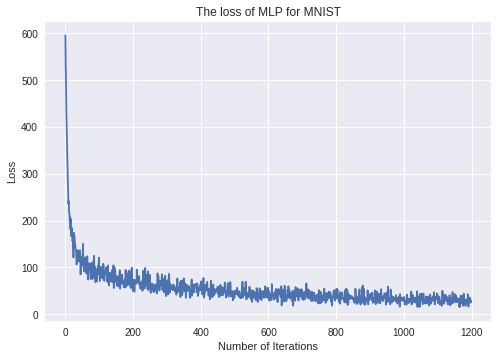

In [207]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("The loss of MLP for MNIST")
plt.show()

### Now, test whether it correctly predicts - predict for the test set

In [0]:
y_pred = torch.zeros(10000, 10)
y_test = torch.zeros(10000)
for i, data in enumerate(testloader, 0):
  inputs, labels = data
  x_, y_ = preprocess(inputs, labels)
  h1, h1_cache = linear_forward(x_, W1, b1)
  y1, y1_cache = relu_forward(h1)
  h2, h2_cache = linear_forward(y1, W2, b2)
  y2 = softmax(h2)
  y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = y2
  y_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = y_

### Make it back to original format - 1 to 10 from one-hot vector

In [0]:
def inv_categorical(y):
  y_inv = torch.argmax(y, 1).type(torch.float)
  return y_inv

In [0]:
y_predi = inv_categorical(y_pred)

### Check how many it correctly predicts - it is more than 96%

In [181]:
torch.sum(y_predi == y_test).type(torch.float) / 10000

tensor(0.9629)